In [1]:
import scipy.ndimage
from numpy.linalg import norm
import pandas as pd
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [9]:
random.seed(100)

d = 1024
s = 16 # number of nonzero elements of xsharp
std = 0.5

def training_set(n):
    x_train = zeros((d, n))
    idx = random.permutation(d)
    for i in range(n):
        sel = random.permutation(d)
        sel = sel[0 : s]   # indices of the nonzero elements of xsharp
        xsharp = zeros(d)
        xsharp[sel] = sign(randn(s)) * (1 - 0.3 * rand(s))
        x_train[:, i] = xsharp / norm(xsharp, ord=2)
    eps_train = np.zeros((d, n))
    for i in range(n):
        eps_train[:, i] = random.normal(0, std, d)
        
    y_train = x_train + eps_train
    return x_train, y_train

N_train = 10000
x_train, y_train = training_set(N_train)  # every element is in a column

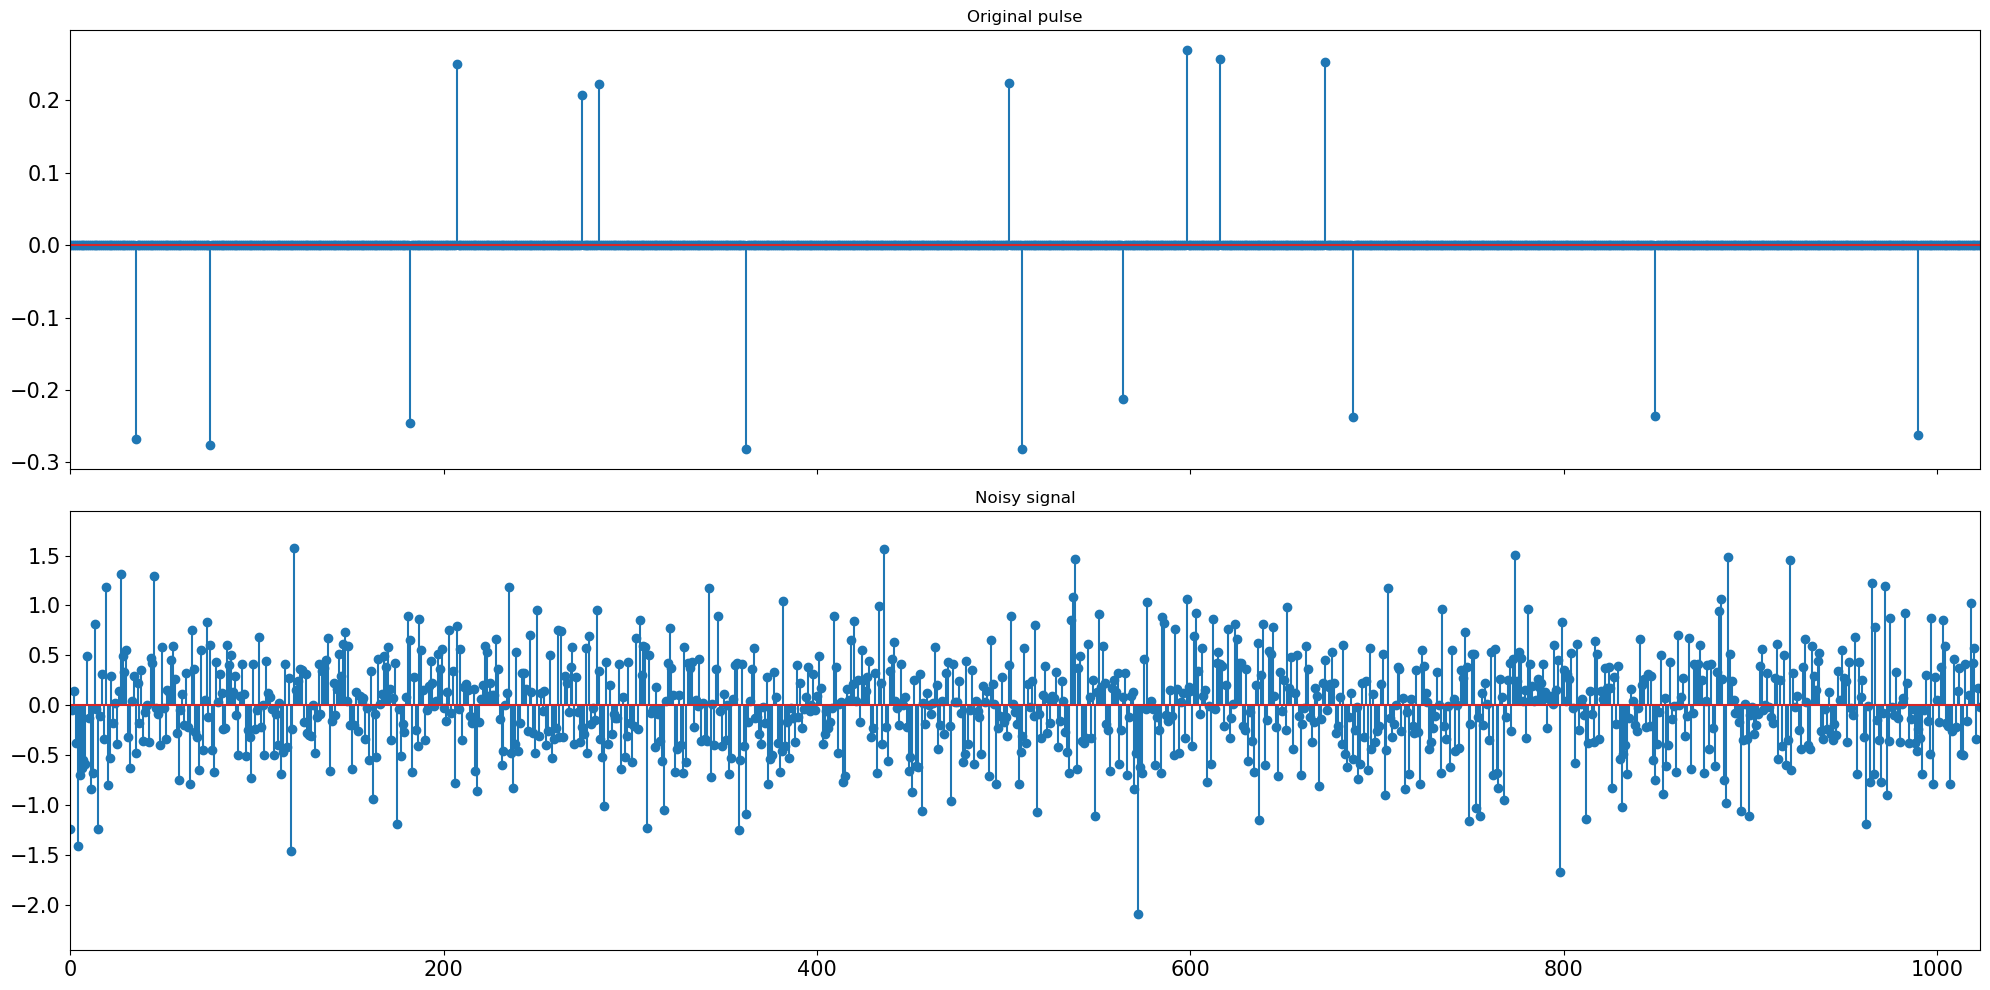

In [10]:
fig, (ax_orig, ax_filtered) = plt.subplots(2, 1, sharex=True, figsize=(20, 10), dpi=100)
ax_orig.stem(x_train[:, 0])
ax_orig.set_title('Original pulse')
ax_orig.set_xlim(0, d - 1)
ax_orig.tick_params(axis='y', labelsize=15)

ax_filtered.stem(y_train[:, 0])
ax_filtered.set_title('Noisy signal')
ax_filtered.margins(0, 0.1)
ax_filtered.tick_params(axis='y', labelsize=15)

plt.xticks(fontsize=15)
plt.savefig("./noisy_sparse_signal.pdf", bbox_inches='tight')
plt.tight_layout()
plt.show()

In [ ]:
 #Denoising functions

In [4]:
# We compute here D_||.||_1(x, y). Inputs vectors, outputs number
def breg_dist_l1(x, y):
    return norm(x, ord=1) - norm(y, ord=1) - dot(sign(y), x - y)

    
# soft thresholding function here:
def st(x, Lambda):
    return clip(x, -Lambda, Lambda)

def train_l1(la):  # lamb is a number here
    distances = zeros(N_train)
    f_lasso = array([st(y, la) for y in y_train.T])
    for i in range(N_train):
        distances[i] = breg_dist_l1(x_train[:, i], f_lasso[i])
    return average(distances)


def train_l1n(n, la):  # lamb is a number here
    x_tr, y_tr = training_set(n)
    distances = zeros(n)
    f_lasso = np.array([st(y, la) for y in y_tr.T])
    for i in range(n):
        distances[i] = breg_dist_l1(x_tr[:, i], f_lasso[i])
    return average(distances)


def cvlambda(n, lamb):  # here lambda is a vector
    l1_err = np.array([train_l1n(n, l) for l in lamb])
    return l1_err.min(), lamb[argmin(l1_err)]


def get_lambda_star(lamb):  # here lambda is a vector
    l1_err = np.array([train_l1(l) for l in lamb])
    return lamb[argmin(l1_err)], l1_err.min()


def get_lambda_hat(L_star, la, Nvec, iters):  # here lamb is a vector
    Deltan = zeros((len(Nvec), iters))
    for i in range(len(Nvec)):
        for j in range(iters):
            Deltan[i, j] = abs(L_star - cvlambda(Nvec[i], la)[0])
    return Deltan 


In [12]:
lamb = logspace(-4, 1, num=50)

lambda_star, L_lambda_star = get_lambda_star(lamb)

In [ ]:
lambda_star

In [ ]:
# We plot here the ER plot

In [15]:
N_vec = np.arange(10, 160, 10)
n_it = 30  # The perfect number of iterations is 30

deltalasso = get_lambda_hat(L_lambda_star, lamb, N_vec, n_it)

In [16]:
Deltalasso = np.zeros(np.shape(deltalasso))
for i in range(len(deltalasso)):
    Deltalasso[i] = deltalasso[i] * np.sqrt(N_vec[i])

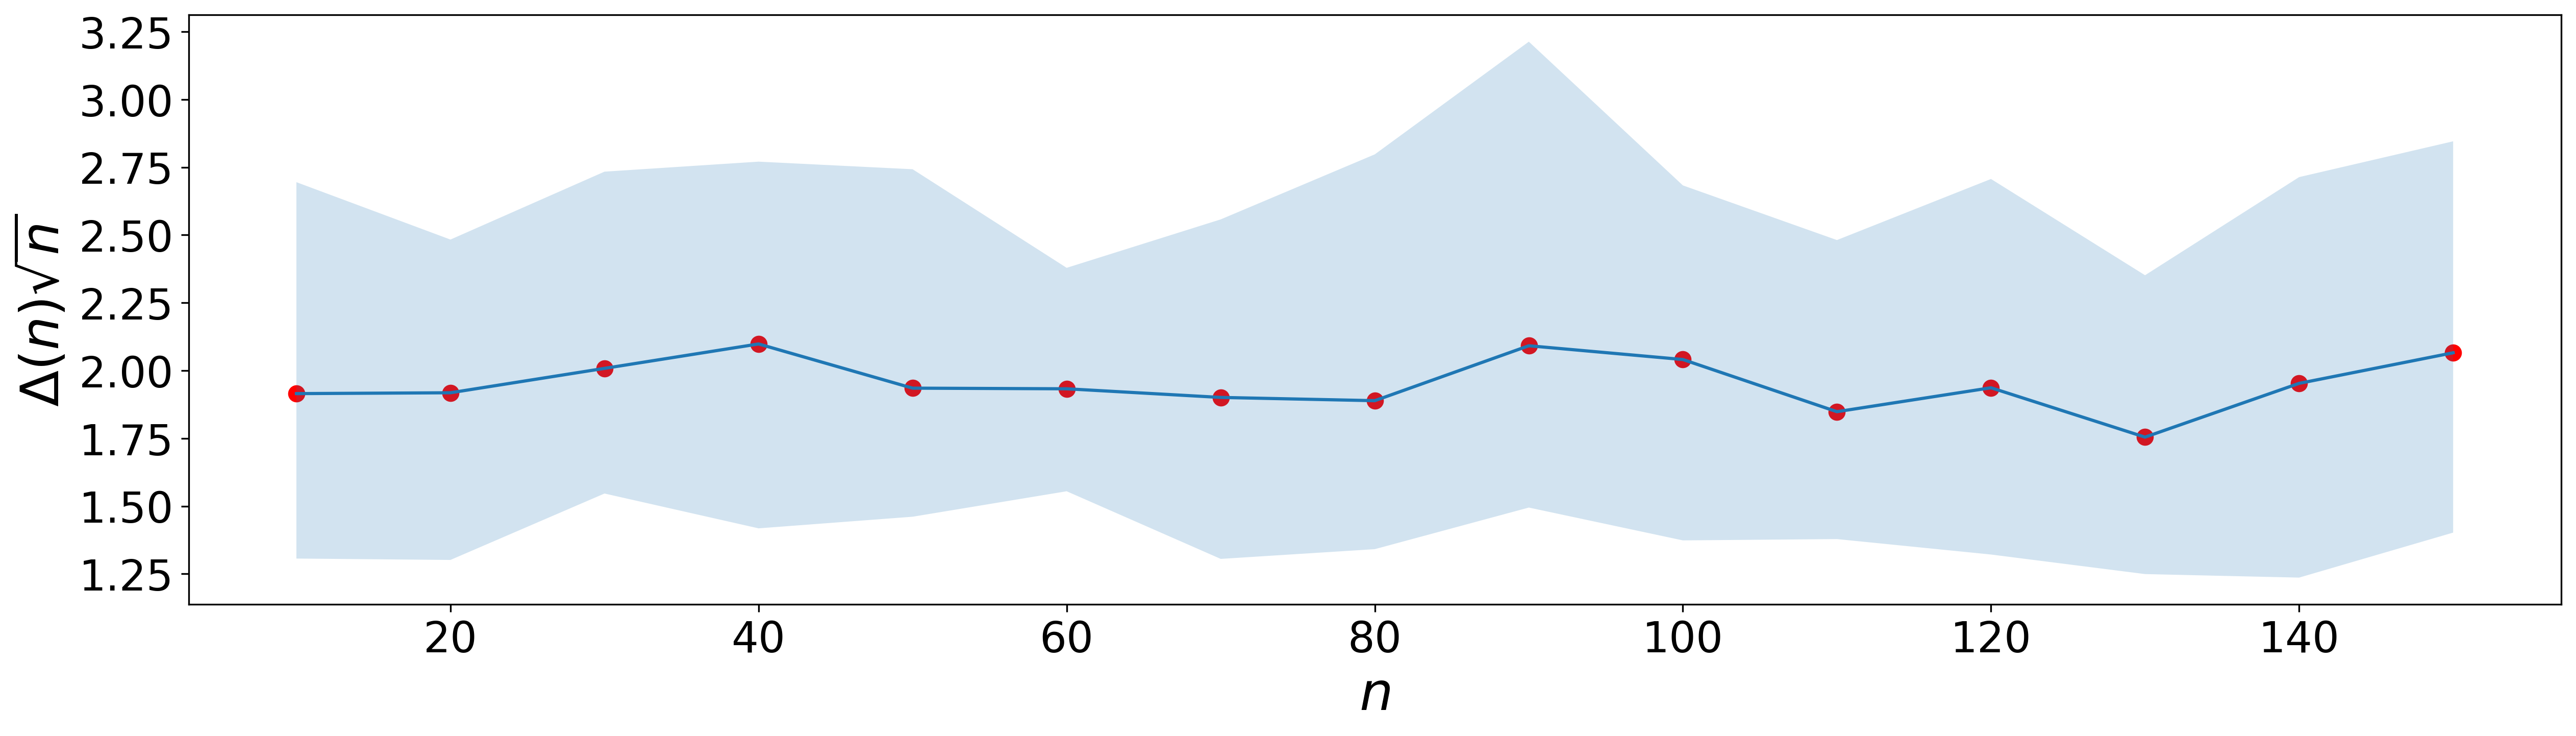

In [20]:
dflasso = pd.DataFrame(Deltalasso)
meanlasso = dflasso.mean(axis='columns') 
lowerlasso = np.quantile(Deltalasso, 0.05, axis=1)
upperlasso = np.quantile(Deltalasso, 0.95, axis=1)

# Figures

plt.close('all')
fig, ax1 = plt.subplots(figsize=(20, 5), dpi=300)
ax1.plot(N_vec, meanlasso, '-', label='Lasso')
ax1.scatter(N_vec, meanlasso, color='red', s=50) 
ax1.fill_between(N_vec, lowerlasso, upperlasso, alpha=0.2)
ax1.set_ylabel(r'$\Delta(n)\sqrt{n}$', fontsize=25)
ax1.set_xlabel(r'$n$', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("./ER_lasso_denoising.pdf", bbox_inches='tight')  # This shud go before show
plt.show(block=False)